# Example of a sinusoid function with missing data (interpolation).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from UQ_in_ML.general_utils import *
from UQ_in_ML.epistemic_regressors import (
    Regressor, BayesByBackprop, BayesByBackpropMixture, alphaBB, ModelAveragingLOO, ModelAveragingLOOalphaBB,
    ModelAveragingInfoCriteria)

In [2]:
fontsize = 15
ylim = (-1.25, 1.25); xlim = (-1., 1.)
set_axis_limits = lambda x: (x.set_ylim(ylim) and x.set_xlim(xlim))
set_labels = lambda x: (x.set_xlabel(r'input $X$', fontsize=fontsize) and x.set_ylabel(
    r'output $y$', fontsize=fontsize))
set_yticks = lambda x: x.set_yticks([-1., -0.5, 0, 0.5, 1.])
set_xticks = lambda x: x.set_xticks([-1., -0.5, 0., 0.5, 1.])
set_stuff = lambda x: (set_labels(x) and set_axis_limits(x) and set_yticks(x) and set_xticks(x) 
                       and plt.xticks(fontsize=13) and plt.yticks(fontsize=13))
kwargs_data = {'color': 'blue', 'linestyle': 'none', 'marker': 'x', 'markersize': 9, 'label': 'training data'}
colors_layers = ['green', 'blue', 'red', 'orange', 'brown', 'purple', 'cyan']
markers_layers = ['o', '+', 'x', 'd', 's', '+']

def plot_loss(loss_history):
    n_epochs = len(loss_history)
    fig, ax = plt.subplots(figsize=(10, 2.5), ncols=2)
    ax[0].plot(np.arange(1, n_epochs+1), loss_history)
    ax[0].set_xlabel('epochs 1 to last'); ax[0].set_ylabel('loss')
    ax[1].plot(np.arange(n_epochs//2+1, n_epochs+1), loss_history[n_epochs//2:])
    ax[1].set_xlabel('epochs {} to last'.format(n_epochs//2)); ax[1].set_ylabel('loss')
    return fig, ax

def plot_loss(loss_history):
    n_epochs = len(loss_history)
    fig, ax = plt.subplots(figsize=(10, 2.5), ncols=2)
    ax[0].plot(np.arange(1, n_epochs+1), loss_history)
    ax[0].set_xlabel('epochs 1 to last'); ax[0].set_ylabel('loss')
    ax[1].plot(np.arange(n_epochs//2+1, n_epochs+1), loss_history[n_epochs//2:])
    ax[1].set_xlabel('epochs {} to last'.format(n_epochs//2)); ax[1].set_ylabel('loss')
    return fig, ax

def plot_convergence_VI(weights_mean, weights_std, weights_to_track):
    fig, ax = plt.subplots(figsize=(13,3.5), ncols=2)
    for l, (means, stds) in enumerate(zip(weights_mean[:-1], weights_std[:-1])):
        for j, (w_mean, w_std) in enumerate(zip(means.T, stds.T)):
            alpha = 0.15+j*0.8/weights_to_track[l]
            ax[0].plot(w_mean, color=colors_layers[l], alpha=alpha)
            ax[1].plot(w_std, color=colors_layers[l], alpha=alpha)
    ax[0].set_xlabel('epochs'); ax[0].set_ylabel(r'$\mu$'); 
    ax[0].set_title(r'Convergence of means $\mu_{i}$')
    ax[1].set_xlabel('epochs'); ax[1].set_ylabel(r'$\sigma$'); 
    ax[1].set_title(r'Convergence of std. devs. $\sigma_{i}$')
    return fig, ax

def plot_VI_mask(VI_mean, VI_std, fig=None, ax=None):
    from scipy.stats import norm
    if ax is None:
        fig, ax = plt.subplots(figsize=(18, 3.), ncols=len(VI_mean))
    for i, (mu, sig) in enumerate(zip(VI_mean, VI_std)):
        for m, s in zip(mu.reshape((-1,)), sig.reshape((-1,))):
            d = norm(loc=m, scale=s)
            md, vd = d.stats(moments='mv')
            xd = np.linspace(md-3.*np.sqrt(vd), md+3.*np.sqrt(vd), 200)
            ax[i].plot(xd, d.pdf(xd))
    for i in range(4):
        ax[2 * i].set_title(r'$W_{}$'.format(i))#; ax[0].set_xlim([-2.5, 2.5])
        ax[2 * i + 1].set_title(r'$b_{}$'.format(i))#; ax[1].set_xlim([-2.5, 0])
    return fig, ax

In [3]:
def plot_results_vi(reg, ns=10000):
    plot_loss(reg.loss_history)
    plt.show()
    plot_convergence_VI(reg.variational_mu_history, reg.variational_sigma_history, reg.weights_to_track)
    plt.show()

    VI_mean, VI_std = reg.return_marginals()
    fig, ax = plot_VI_mask(VI_mean=VI_mean, VI_std=VI_std)
    plt.show(fig)

    y_mean, y_std, y_perc, y_MC = reg.predict_uq(
        X=x_plot, ns=ns, return_std=True, return_percentiles=(2.5, 97.5), return_MC=2, 
        aleatoric_in_std_perc=True, aleatoric_in_MC=False)
    fig, ax = plt.subplots(figsize=(6, 4.))
    plot_mean_percentiles(x_plot, y_perc=y_perc, ax=ax, y_mean=y_mean, var_aleatoric=var_n)
    #plot_mean_MC(x_plot, y_MC=y_MC, ax=ax, color_MC='red', label_MC='one posterior draw')
    ax.plot(xn, yn, **kwargs_data)
    ax.legend(loc='upper center', bbox_to_anchor=(0.25, 1.17), ncol=2, fancybox=True, shadow=True)
    set_stuff(ax)
    fig.tight_layout()
    plt.show()

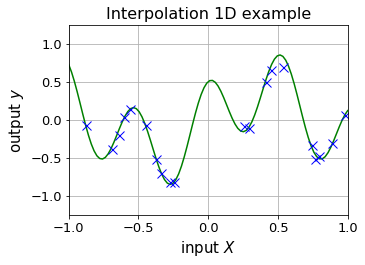

In [4]:
var_n = 0.05 ** 2
f = lambda x, noisy: 0.4*np.sin(4 * x)+0.5*np.cos(12 * x)+noisy*np.sqrt(var_n)*np.random.normal(size=x.shape)

n_data = 20
xn = 1/5 * np.array([[-1.23374131], [-2.80075168], [-3.44975161], [-3.21186531], [-3.02209586], [-2.21373764], [-4.37775872],
            [-1.86404408], [-1.69559337], [-1.37603453], [ 3.72937   ], [ 4.88684951], [ 2.23649116], [ 2.69073348],
            [ 1.29613003], [ 3.95513359], [ 3.83697005], [ 1.45216711], [ 4.42576355], [ 2.07597818]])
yn = np.array([-0.8181956697783953, 0.13885402687227927, -0.3862388281350327, -0.20234915578844812, 
    0.03000639994622538, -0.06849287803937654, -0.07642553448272046, -0.5232257730716847, 
        -0.7023192220709934, -0.8190169865472378, -0.3285415162946372, 0.05488363929789496, 
            0.6563808735923208, 0.6941414577967285, -0.08382934737250632, -0.47515928440184424, 
                -0.5146741885584126, -0.11555280503711199, -0.31140762228445024, 0.4945424732107972]).reshape((-1, 1))
x_plot = np.linspace(-1., 1., 100).reshape((-1, 1))

fig, ax = plt.subplots(figsize=(5, 3.5), ncols=1)
ax.plot(x_plot, f(x_plot, False), **{'color': 'green', 'linestyle': '-', 'label': 'data generating function'})
ax.plot(xn, yn, color='blue', linestyle='none', marker='x', markersize=9, label='noisy training data')
set_stuff(ax)
ax.grid(True)
ax.set_title('Interpolation 1D example', fontsize=16)
#plt.legend(loc='upper center', bbox_to_anchor=(0.35, 1.05), ncol=2, fancybox=True, shadow=True)
#plt.legend(fontsize=13, loc='lower right')
#plt.savefig('sinusoid_true_f.pdf', bbox_inches='tight')
plt.show()

# Set network

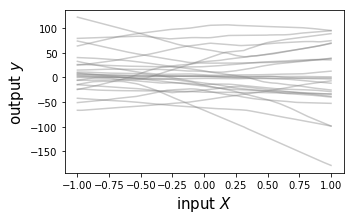

In [5]:
nn = {'input_dim': 1, 
      'output_dim': 1,
      'var_n': var_n,
      'hidden_units': (20, 20, 20),
      'activation': tf.nn.relu,
      'prior_means': 0.,
      'prior_stds': 1.}
weights_to_track = [] # track 5 kernel weights in each uq layer, and no bias
[weights_to_track.extend([4, 1]) for j in range(len(nn['hidden_units']) + 1)]

training_dict = {'epochs': 8000, 'lr': 0.005, 'ns': 20}

fig, ax = plt.subplots(figsize=(5, 3))
reg = Regressor(**nn)
y_MC = reg.predict_uq_from_prior(X=x_plot, ns=25)
plot_mean_MC(x_plot, y_MC, ax)
set_labels(ax)
plt.show()

# BayesBackprop vs. alphaBB

Instructions for updating:
Use `tf.cast` instead.
15.396322965621948


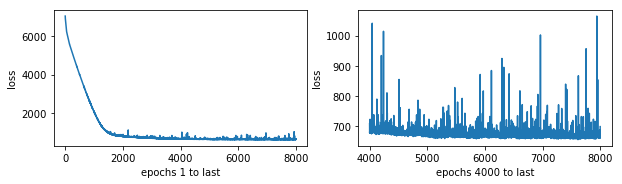

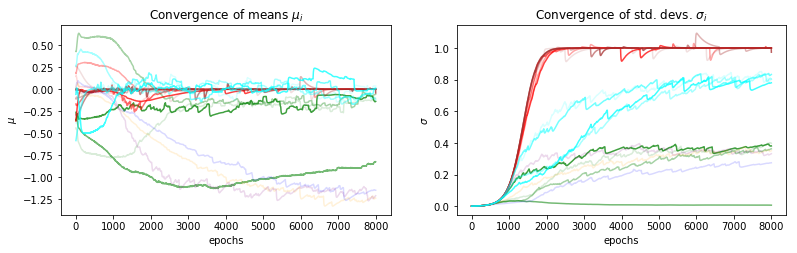

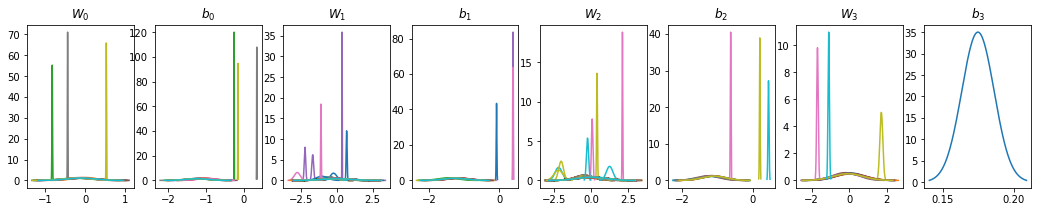

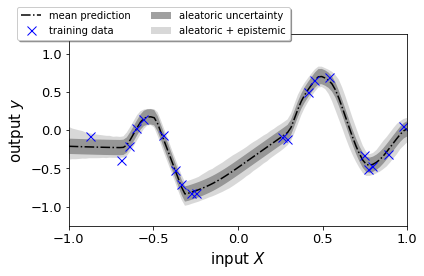

In [6]:
t0 = time.time()
reg_0 = BayesByBackprop(weights_to_track=weights_to_track, analytical_grads=True, **nn)
reg_0.fit(X=xn, y=yn, **training_dict)
print(time.time() - t0)
plot_results_vi(reg_0)

20.40598487854004


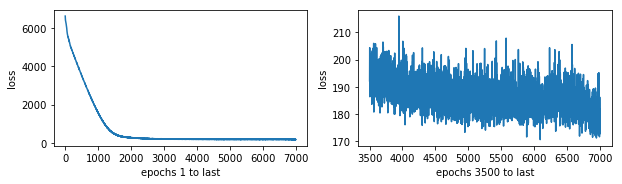

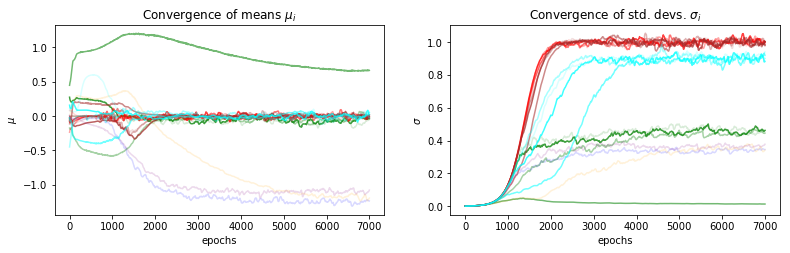

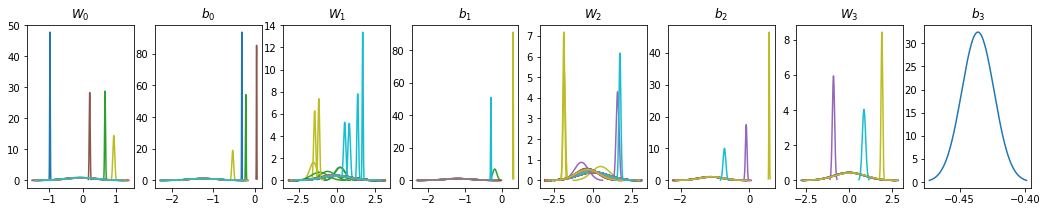

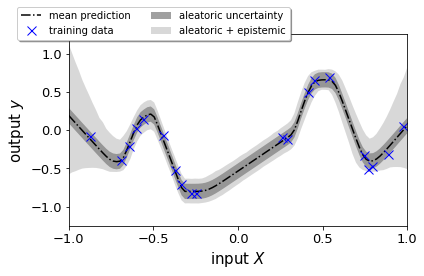

In [11]:
t0 = time.time()
reg_a1 = alphaBB(alpha=0.1, weights_to_track=weights_to_track, **nn)
reg_a1.fit(X=xn, y=yn, **training_dict)
print(time.time() - t0)
plot_results_vi(reg_a1)

21.924206972122192


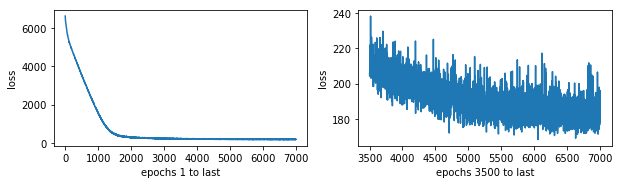

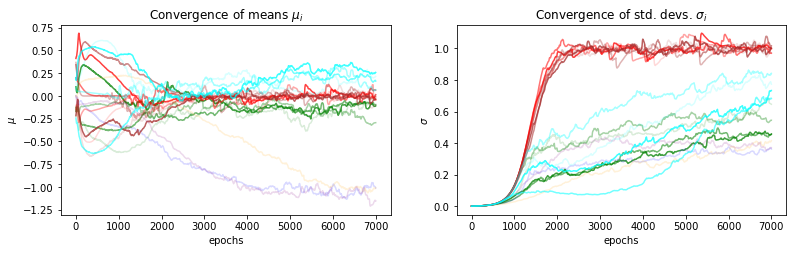

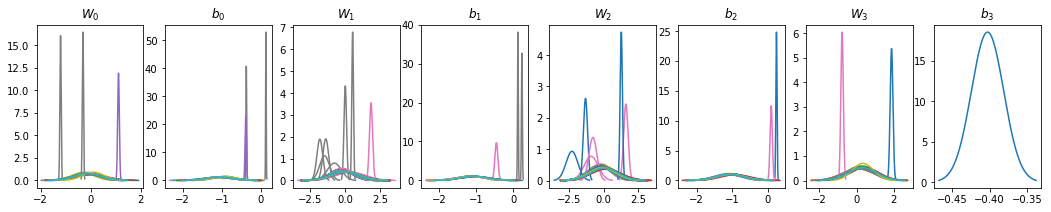

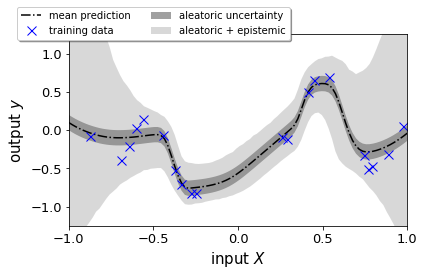

In [12]:
t0 = time.time()
reg_a1 = alphaBB(alpha=0.2, weights_to_track=weights_to_track, **nn)
reg_a1.fit(X=xn, y=yn, **training_dict)
print(time.time() - t0)
plot_results_vi(reg_a1)

In [15]:
t0 = time.time()
reg_fig_0 = BayesByBackprop(weights_to_track=weights_to_track, analytical_grads=True, random_seed=123, **nn)
reg_fig_0.fit(X=xn, y=yn, **training_dict)
print(time.time()-t0)

15.255889892578125
15.188756942749023


In [17]:
t0 = time.time()
reg_fig_1 = BayesByBackprop(weights_to_track=weights_to_track, analytical_grads=True, random_seed=5678, **nn)
reg_fig_1.fit(X=xn, y=yn, **training_dict)
print(time.time()-t0)

15.706486940383911


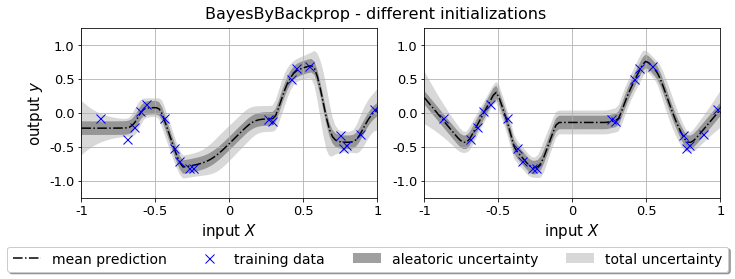

In [18]:
# Actual figures that I will need
fig, ax = plt.subplots(ncols=2, figsize=(10, 3.3))
stat_to_plot = 'std'   # 'std' or 'perc'
dict_predict = {'return_std': False, 'return_percentiles': (2.5, 97.5), 'return_MC': 0, 
                'aleatoric_in_std_perc': True, 'aleatoric_in_MC': False, 'ns': 10000}
if stat_to_plot == 'std':
    dict_predict.update({'return_std': True, 'return_percentiles': ()})
for i, reg in enumerate([reg_fig_0, reg_fig_1]):
    y_mean, y_uq = reg.predict_uq(X=x_plot, **dict_predict)
    plot_mean_uq(x=x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax[i], y_mean=y_mean, var_aleatoric=var_n)
    ax[i].plot(xn, yn, **kwargs_data)
    set_stuff(ax[i])
    if i > 0:
        ax[i].set_ylabel('')
    ax[i].set_yticklabels([-1.0, -0.5, 0.0, 0.5, 1.0], fontsize=13)
    ax[i].set_xticklabels([-1, -0.5, 0, 0.5, 1], fontsize=13)
    ax[i].grid(True)
    #if i in [0, 2]:
    #    ax[i].set_title('                                              ' + title, fontsize=16)
fig.legend(
    (ax[0].lines[0], ax[0].lines[1], ax[0].patches[0], ax[0].patches[1]),
    ('mean prediction', 'training data', 'aleatoric uncertainty', 'total uncertainty'),
    ncol=4, fancybox=True, shadow=True, fontsize=14,
    bbox_to_anchor=(1., 0.05), bbox_transform=plt.gcf().transFigure)
fig.suptitle(r'BayesByBackprop - different initializations', fontsize=16, y=1.03)
fig.tight_layout()
#plt.savefig('various_algos_sinusoid_2_cmame.pdf', bbox_inches = "tight")
plt.show()

In [8]:
t0 = time.time()
reg_fig_2 = alphaBB(weights_to_track=weights_to_track, alpha=0.1, random_seed=123, **nn)
reg_fig_2.fit(X=xn, y=yn, **training_dict)
print(time.time()-t0)

t0 = time.time()
reg_fig_3 = alphaBB(weights_to_track=weights_to_track, alpha=0.2, random_seed=123, **nn)
reg_fig_3.fit(X=xn, y=yn, **training_dict)
print(time.time()-t0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
23.723661184310913
24.723492860794067


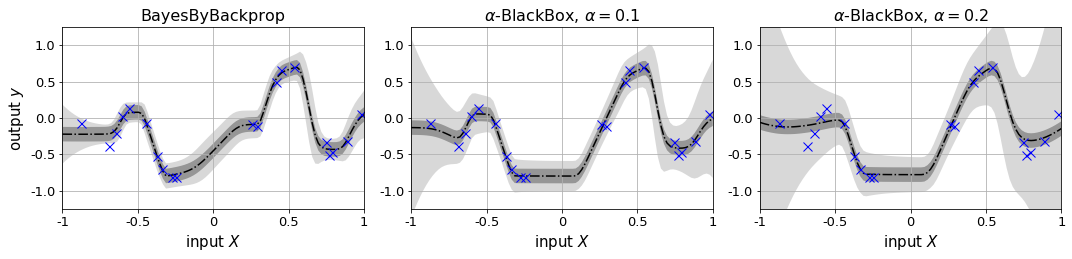

In [9]:
# Actual figure that I will need
stat_to_plot = 'std'   # 'std' or 'perc'
fig, ax = plt.subplots(ncols=3, figsize=(15, 3.7))
dict_predict = {'return_std': False, 'return_percentiles': (2.5, 97.5), 'return_MC': 0, 
                'aleatoric_in_std_perc': True, 'aleatoric_in_MC': False}
if stat_to_plot == 'std':
    dict_predict.update({'return_std': True, 'return_percentiles': ()})
# MCMC
for i in range(3):
    dict_predict['ns'] = 10000
    if i == 0:
        reg = reg_fig_0
        title = 'BayesByBackprop'
    elif i == 1:
        reg = reg_fig_2
        title = r'$\alpha$-BlackBox, $\alpha=0.1$'
    elif i == 2:
        reg = reg_fig_3
        title = r'$\alpha$-BlackBox, $\alpha=0.2$'
    y_mean, y_uq = reg.predict_uq(X=x_plot, **dict_predict)
    plot_mean_uq(x=x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax[i], y_mean=y_mean, var_aleatoric=var_n)
    ax[i].plot(xn, yn, **kwargs_data)
    set_stuff(ax[i])
    if i > 0:
        ax[i].set_ylabel('')
    ax[i].set_yticklabels([-1.0, -0.5, 0.0, 0.5, 1.0], fontsize=13)
    ax[i].set_xticklabels([-1, -0.5, 0, 0.5, 1], fontsize=13)
    ax[i].grid(True)
    ax[i].set_title(title, fontsize=16)
#fig.legend(
#    (ax[0].lines[0], ax[0].lines[1], ax[0].patches[0], ax[0].patches[1]),
#    ('mean prediction', 'training data', 'aleatoric uncertainty', 'epistemic + aleatoric'),
#    ncol=4, fancybox=True, shadow=True, fontsize=15,
#    bbox_to_anchor=(0.85, 0), bbox_transform=plt.gcf().transFigure)
fig.tight_layout()
#plt.savefig('various_algos_sinusoid_cmame.pdf', bbox_inches = "tight")
plt.show()

Time for training = 674.150386095047
Acc rate = 84.72


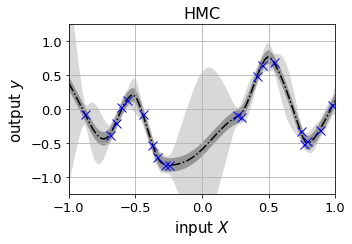

Diagnostics for parameters
av ESS = 38.84696578979492
av Rhat = 1.592634916305542
Diagnostics for outputs
ESS
[ 542.54449012 1017.66004201  881.11551291  619.11738406 1105.69682156]
Rhat
[1.0682027  1.03121392 1.0009692  1.00130334 1.00572362]
901
200000
5000


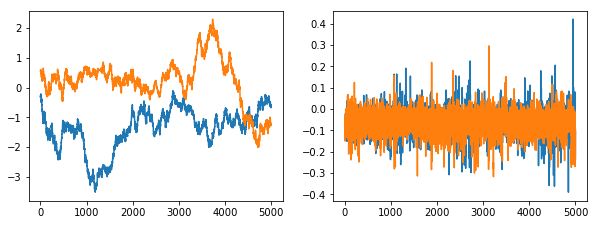

In [8]:
# MCMC alone
stat_to_plot = 'std'   # 'std' or 'perc'
fig, ax = plt.subplots(figsize=(5, 3.5))
dict_predict = {'return_std': False, 'return_percentiles': (2.5, 97.5), 'return_MC': 0, 
                'aleatoric_in_std_perc': True, 'aleatoric_in_MC': False}
if stat_to_plot == 'std':
    dict_predict.update({'return_std': True, 'return_percentiles': ()})
# MCMC
import pickle
folder = '/Users/audreyolivier/Data/UQ_in_ML_MCMC_runs/'
with open('MCMC_runs/hmc_sinusoid_20210516.pkl', 'rb') as f:
    mcmc_dict = pickle.load(f)
print('Time for training = {}'.format(mcmc_dict['time_training']))
print('Acc rate = {}'.format(np.mean(mcmc_dict['acceptance_rate'])))
reg = Regressor(**nn)
y_mean, y_uq = reg.predict_uq_from_samples(
    X=x_plot, network_weights=mcmc_dict['network_weights'], **dict_predict)
plot_mean_uq(x=x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax, y_mean=y_mean, var_aleatoric=var_n)
ax.plot(xn, yn, **kwargs_data)
set_stuff(ax)
ax.grid(True)
ax.set_title('HMC', fontsize=16)
#fig.legend(
#    (ax.lines[0], ax.lines[1], ax.patches[0], ax.patches[1]),
#    ('mean prediction', 'training data', 'aleatoric uncertainty', 'epistemic + aleatoric'),
#    ncol=4, fancybox=True, shadow=True, fontsize=14,
#    bbox_to_anchor=(0.8, 0), bbox_transform=plt.gcf().transFigure)
fig.tight_layout()
plt.savefig('sinusoid_mcmc_cmame.pdf', bbox_inches = "tight")
plt.show()

# Look at a couple of chains
print('Diagnostics for parameters')
print('av ESS = {}'.format(mcmc_dict['diagnostics']['ESS_params']))
print('av Rhat = {}'.format(mcmc_dict['diagnostics']['Rhat_params']))

print('Diagnostics for outputs')
print('ESS')
print(np.array(mcmc_dict['diagnostics']['ESS_outpt'])[:, 1])
print('Rhat')
print(np.array(mcmc_dict['diagnostics']['Rhat_outpt'])[:, 1])
    
num_iterations = mcmc_dict['network_weights'][0].shape[0] // mcmc_dict['nchains']
print(reg.n_weights)
print(num_iterations * mcmc_dict['n_jump'] + mcmc_dict['n_burnin'])
print(num_iterations)
fig, ax = plt.subplots(ncols=2, figsize=(10, 3.5))
for j in range(2):
    weights_j = [w[j * num_iterations:(j+1) * num_iterations] for w in mcmc_dict['network_weights']]
    ymean, yMC = reg.predict_uq_from_samples(
        X=np.array([[0.95, ], ]), network_weights=weights_j, return_MC=num_iterations, 
        return_std=False, return_percentiles=())
    ax[0].plot(weights_j[0][:, 0, 0])
    ax[1].plot(yMC[:, 0, 0])
plt.show()

# Mixture of Gaussians

In [16]:
reg_m = BayesByBackpropMixture(ncomp=5, weights_to_track=weights_to_track, lower_bound=True, **nn)
reg_m.fit(X=xn, y=yn, **training_dict)

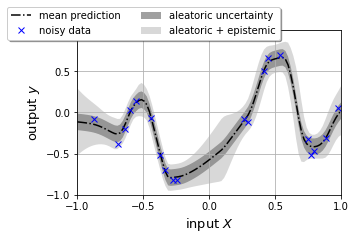

In [18]:
stat_to_plot = 'std'   # 'std' or 'perc'
dict_predict = {'return_std': False, 'return_percentiles': (2.5, 97.5), 'return_MC': 0, 
                'aleatoric_in_std_perc': True, 'aleatoric_in_MC': False, 'ns': 10000}
if stat_to_plot == 'std':
    dict_predict.update({'return_std': True, 'return_percentiles': ()})
y_mean, y_uq = reg_m.predict_uq(X=x_plot, **dict_predict)
fig2, ax = plt.subplots(figsize=(5., 3.5))
plot_mean_uq(x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax, y_mean=y_mean, var_aleatoric=var_n)
#plot_mean_MC(x_plot, y_MC=y_MC, ax=ax, color_MC='red', label_MC='one posterior draw')
ax.plot(xn, yn, **kwargs_data)
ax.legend(loc='upper center', bbox_to_anchor=(0.25, 1.17), ncol=2, fancybox=True, shadow=True)
set_stuff(ax)
ax.set_xticks([-1., -0.5, 0., 0.5, 1.])
ax.grid(True)
fig2.tight_layout()
#fig2.savefig('sinusoid_mixture.pdf')
plt.show(fig2)

## Part 2: Average over several models

In [6]:
def plot_regressors(regressors, stat_to_plot, titles, figsize=(20, 3.), ncols=None, nrows=None, ns=10000):
    dict_predict = {'return_std': False, 'return_percentiles': (2.5, 97.5), 'return_MC': 0, 
                    'aleatoric_in_std_perc': True, 'aleatoric_in_MC': False}
    if stat_to_plot == 'std':
        dict_predict.update({'return_std': True, 'return_percentiles': ()})
    
    if ncols is None:
        ncols = len(regressors)
    if nrows is None:
        nrows = 1
    fig = plt.figure(figsize=figsize)
    for i, (reg_props, title) in enumerate(zip(regressors, titles)):
        reg = set_properties_vi(*reg_props)
        ax = fig.add_subplot(nrows, ncols, i+1)
        y_mean, y_uq = reg.predict_uq(X=x_plot, ns=ns, **dict_predict)
        plot_mean_uq(x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax, y_mean=y_mean, var_aleatoric=var_n)
        ax.plot(xn, yn, **kwargs_data)
        set_stuff(ax)
        if i != 0:
            ax.set_ylabel('')
        if titles is not None:
            ax.set_title(title)
        ax.grid(True)
    fig.tight_layout()
    plt.show()
    return fig
    
def plot_av_regressor(model_aving, stat_to_plot, figsize=(5, 3.5), ns=10000):
    dict_predict = {'return_std': False, 'return_percentiles': (2.5, 97.5), 'return_MC': 0, 
                    'aleatoric_in_std_perc': True, 'aleatoric_in_MC': False}
    if stat_to_plot == 'std':
        dict_predict.update({'return_std': True, 'return_percentiles': ()})
        
    fig, ax = plt.subplots(figsize=figsize)
    y_mean, y_uq = model_aving.predict_uq(X=x_plot, ns=ns, **dict_predict)
    plot_mean_uq(x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax, y_mean=y_mean, var_aleatoric=var_n)
    ax.plot(xn, yn, **kwargs_data)
    ax.legend(loc='upper center', bbox_to_anchor=(0.25, 1.17), ncol=2, fancybox=True, shadow=True)
    set_stuff(ax)
    ax.set_xticks([-1., -0.5, 0., 0.5, 1.])
    ax.grid(True)
    fig.tight_layout()
    plt.show()
    return fig

In [7]:
nmodels = 15
#alpha_list = 0.1 * np.random.rand(nmodels)
alpha_list = [5.42766916e-02, 6.87275892e-02, 2.14523479e-02, 7.11486205e-05,
              4.53565904e-02, 1.05661303e-02, 3.93535397e-02, 6.44690929e-02,
              8.30121984e-02, 2.56485246e-03, 5.98552183e-02, 2.08035971e-02,
              1.87373582e-02, 1.47309907e-02, 2.89138780e-02]
#random_seed_list = generate_seeds(nseeds=nmodels, nfigures=4)
random_seed_list = [2738, 1923, 3287, 8741, 3895, 9364, 3145, 4618, 9682, 9724, 7946, 7315, 7123, 3695, 7954]

Adding model with alpha=0.0542766916

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Adding model with alpha=0.0687275892
Adding model with alpha=0.0214523479
Adding model with alpha=7.11486205e-05
Adding model with alpha=0.0453565904
Adding model with alpha=0.0105661303
Adding model with alpha=0.0393535397
Adding model with alpha=0.0644690929
Adding model with alpha=0.0830121984
Adding model with alpha=0.00256485246
Adding model with alpha=0.0598552183
Adding model with alpha=0.0208035971
Adding model with alpha=0.0187373582
Adding model with alpha=0.0147309907
Adding model with alpha=0.028913878
261.1030738353729
[2.5972826e-04 1.1542502e-07 2.2774972e-02 3.4254164e-02 1.7865091e-03
 2.3735052e-01 8.5459471e-02 5.4531563e-02 2.4185416e-05 8.3085231e-02
 9.5540112e-05 1.2534529e-01 2.8176652e-02 7.5271390e-03 3.1932792e-01]
[8.36013543e-05 1.32060433e-08 2.13714704e-02 3.22354443e-02
 1.13

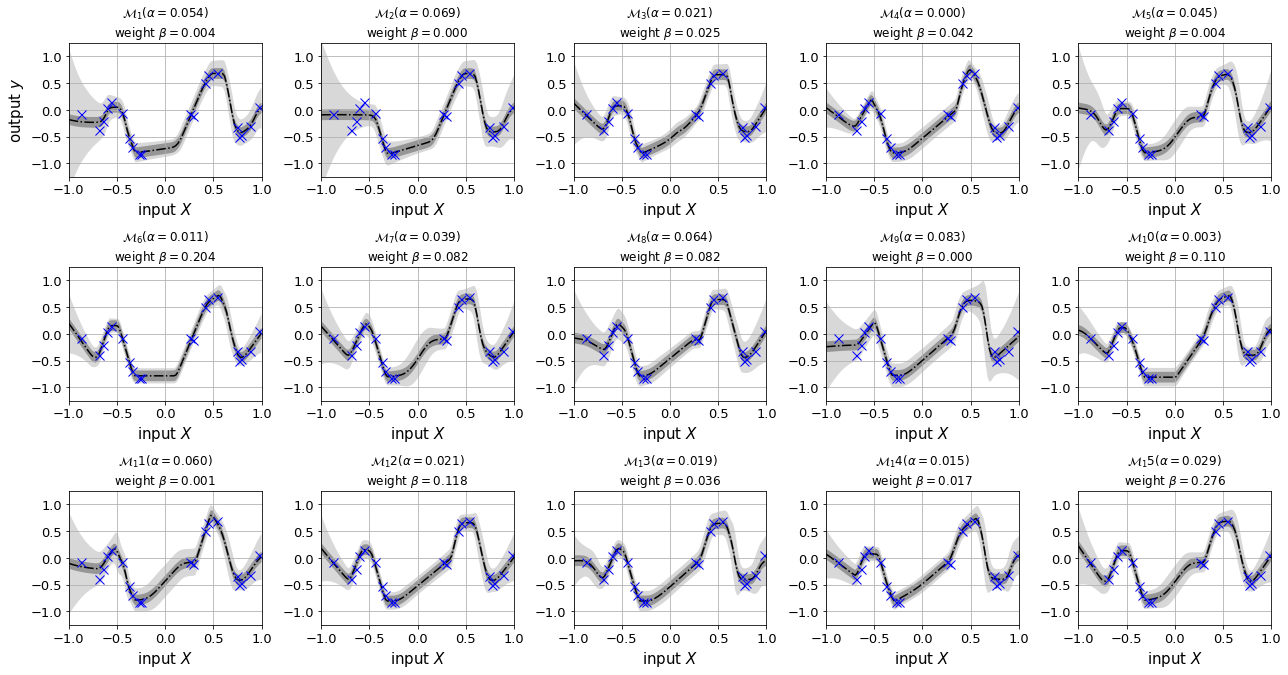

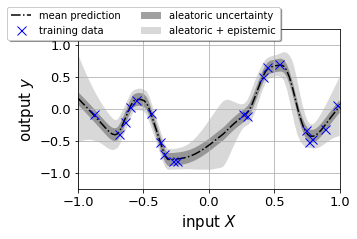

In [8]:
t0 = time.time()
model_aving = ModelAveragingLOOalphaBB(
    nn_dict=nn, training_data=(xn, yn), training_dict=training_dict, n_bootstrap=100,
    alpha_list=alpha_list, random_seed_list=random_seed_list)
print(time.time() - t0)

print(model_aving.weights_elpd)
print(model_aving.weights_modified_elpd)
print(model_aving.weights_elpd_bb)

stat_to_plot = 'std'
weights_attribute = 'weights_elpd_bb'

titles = [r'$\mathcal{}_{}(\alpha={:.3f})$'.format('{M}', i+1, alpha)+'\n'+r'weight $\beta={:.3f}$'.format(w_) 
          for i, (alpha, w_) in enumerate(zip(alpha_list, getattr(model_aving, weights_attribute)))]
fig0 = plot_regressors(regressors=model_aving.regressors, stat_to_plot=stat_to_plot, 
                       titles=titles, figsize=(18, 3. * 4), ns=5000, ncols=5, nrows=4)

fig1 = plot_av_regressor(model_aving, stat_to_plot=stat_to_plot, figsize=(5, 3.5), ns=5000)

In [11]:
t0 = time.time()
model_aving = ModelAveragingLOOalphaBB(
    nn_dict=nn, training_data=(xn, yn), training_dict=training_dict, n_bootstrap=100,
    alpha_list=alpha_list, random_seed_list=random_seed_list)
print(time.time() - t0)

print(model_aving.weights_elpd)
print(model_aving.weights_modified_elpd)
print(model_aving.weights_elpd_bb)

Adding model with alpha=0.0542766916
Adding model with alpha=0.0687275892
Adding model with alpha=0.0214523479
Adding model with alpha=7.11486205e-05
Adding model with alpha=0.0453565904
Adding model with alpha=0.0105661303
Adding model with alpha=0.0393535397
Adding model with alpha=0.0644690929
Adding model with alpha=0.0830121984
Adding model with alpha=0.00256485246
Adding model with alpha=0.0598552183
Adding model with alpha=0.0208035971
Adding model with alpha=0.0187373582
Adding model with alpha=0.0147309907
Adding model with alpha=0.028913878
398.04747581481934
[2.69255834e-04 1.15410167e-07 1.92260984e-02 3.61053646e-02
 1.87395676e-03 2.43892938e-01 8.76594633e-02 5.52264825e-02
 2.17085071e-05 8.44258219e-02 9.79489851e-05 1.22444704e-01
 2.70544626e-02 7.54110701e-03 3.14159632e-01]
[8.82711304e-05 1.34583698e-08 1.78095455e-02 3.41481589e-02
 1.19902264e-03 2.39009717e-01 9.33313608e-02 5.53332060e-02
 8.95894728e-06 7.12957704e-02 3.58445777e-05 1.09774214e-01
 2.11538481

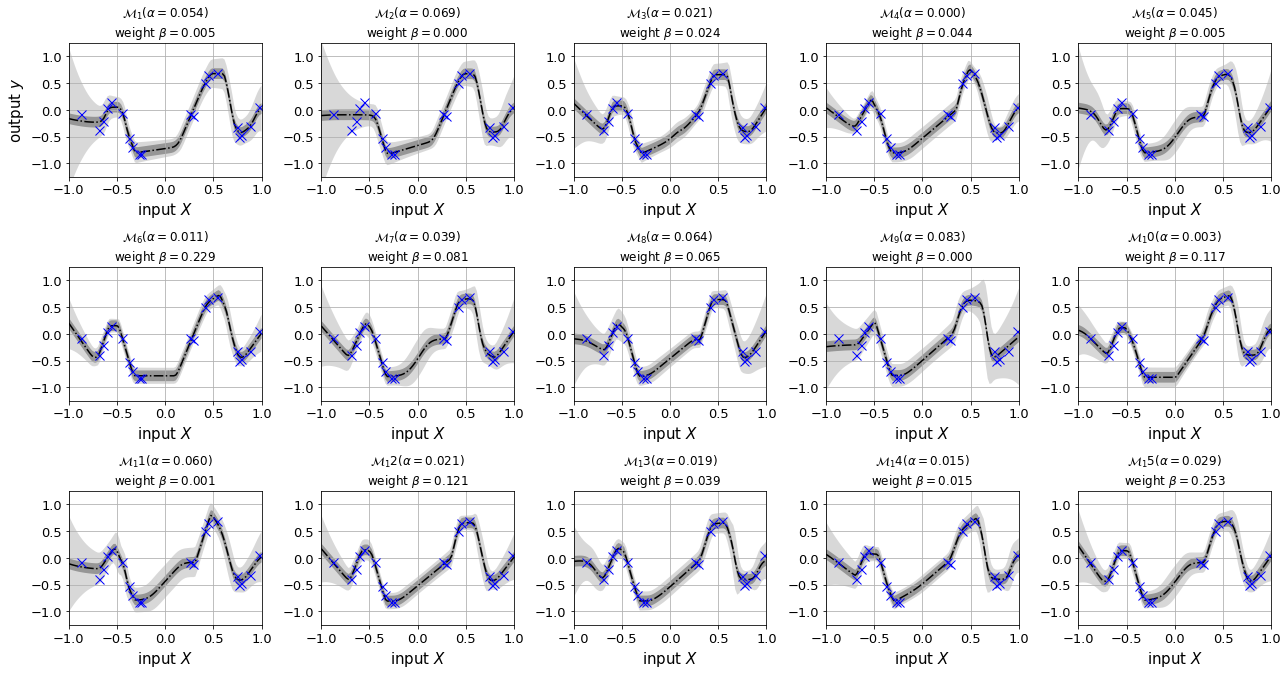

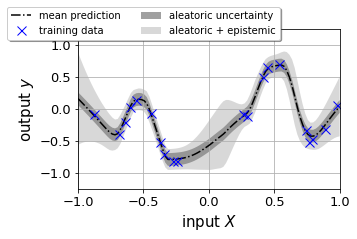

In [12]:
stat_to_plot = 'std'
weights_attribute = 'weights_elpd_bb'

titles = [r'$\mathcal{}_{}(\alpha={:.3f})$'.format('{M}', i+1, alpha)+'\n'+r'weight $\beta={:.3f}$'.format(w_) 
          for i, (alpha, w_) in enumerate(zip(alpha_list, getattr(model_aving, weights_attribute)))]
fig0 = plot_regressors(regressors=model_aving.regressors, stat_to_plot=stat_to_plot, 
                       titles=titles, figsize=(18, 3. * 4), ns=5000, ncols=5, nrows=4)
#fig0.savefig('sinusoid_LOOalphaBB_all_cmame.pdf')

fig1 = plot_av_regressor(model_aving, stat_to_plot=stat_to_plot, figsize=(5, 3.5), ns=5000)
#fig1.savefig('sinusoid_LOOalphaBB_average_cmame.pdf')

In [13]:
t0 = time.time()
model_aving_2 = ModelAveragingLOO(
    nn_dict=nn, training_data=(xn, yn), training_dict=training_dict, n_bootstrap=100,
    alpha_list=alpha_list, random_seed_list=random_seed_list)
print(time.time() - t0)

print(model_aving_2.weights_elpd)
print(model_aving_2.weights_modified_elpd)
print(model_aving_2.weights_elpd_bb)

Adding model with alpha=0.0542766916
Adding model with alpha=0.0687275892
Adding model with alpha=0.0214523479
Adding model with alpha=7.11486205e-05
Adding model with alpha=0.0453565904
Adding model with alpha=0.0105661303
Adding model with alpha=0.0393535397
Adding model with alpha=0.0644690929
Adding model with alpha=0.0830121984
Adding model with alpha=0.00256485246
Adding model with alpha=0.0598552183
Adding model with alpha=0.0208035971
Adding model with alpha=0.0187373582
Adding model with alpha=0.0147309907
Adding model with alpha=0.028913878
5879.877526044846
[4.29345395e-03 7.31622074e-03 6.83109173e-08 4.75493803e-07
 1.16823808e-06 6.00381950e-01 3.89760667e-04 8.53570669e-05
 9.59171927e-05 4.98442744e-07 3.86703222e-01 6.56987998e-04
 7.34237944e-05 1.18832083e-06 3.08100588e-07]
[2.66967664e-03 6.12912072e-03 1.16113026e-08 5.78534645e-08
 2.93815582e-07 7.31335720e-01 1.14603608e-04 3.69215056e-05
 6.41117456e-05 1.06488083e-07 2.59433252e-01 1.92598796e-04
 2.31328076e

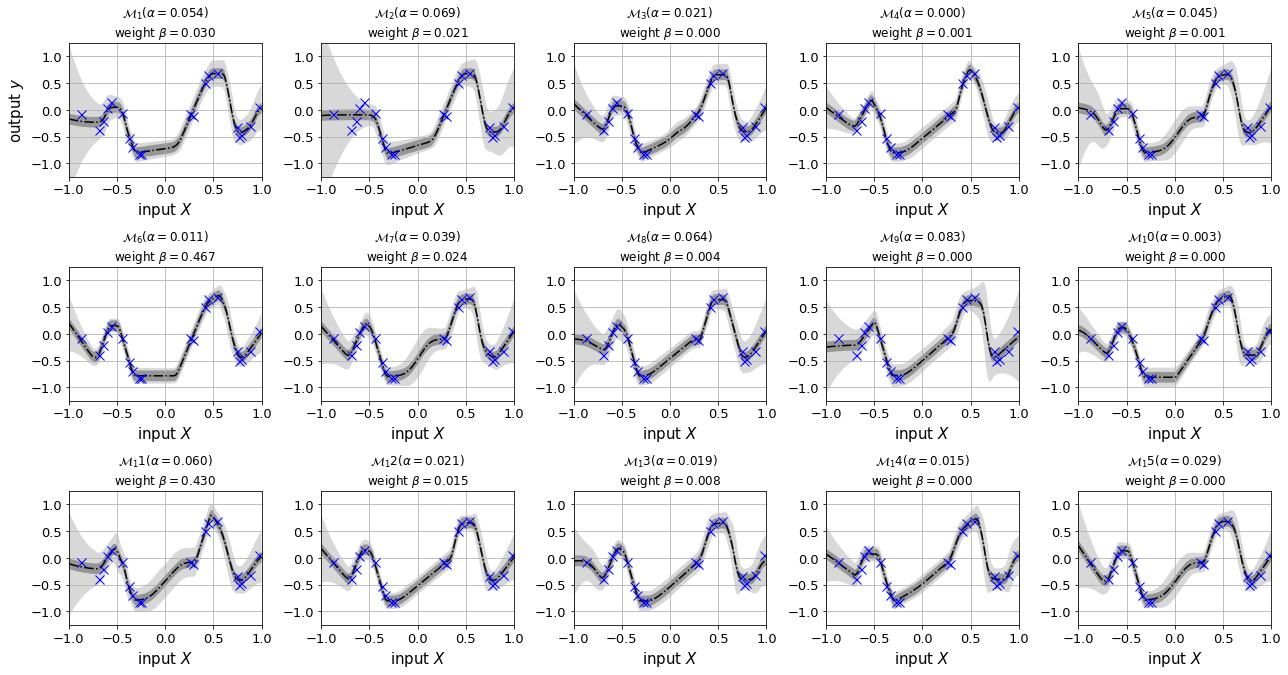

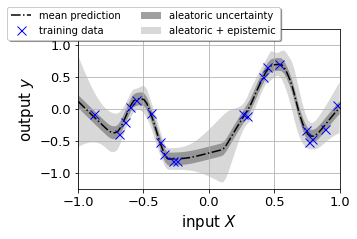

In [14]:
stat_to_plot = 'std'
weights_attribute = 'weights_elpd_bb'

titles = [r'$\mathcal{}_{}(\alpha={:.3f})$'.format('{M}', i+1, alpha)+'\n'+r'weight $\beta={:.3f}$'.format(w_) 
          for i, (alpha, w_) in enumerate(zip(alpha_list, getattr(model_aving_2, weights_attribute)))]
fig0 = plot_regressors(regressors=model_aving_2.regressors, stat_to_plot=stat_to_plot, 
                       titles=titles, figsize=(18, 3. * 4), ns=10000, ncols=5, nrows=4)

fig1 = plot_av_regressor(model_aving_2, stat_to_plot=stat_to_plot, figsize=(5, 3.5), ns=10000)

In [13]:
t0 = time.time()
model_aving_3 = ModelAveragingInfoCriteria(
    nn_dict=nn, training_data=(xn, yn), training_dict=training_dict,
    alpha_list=alpha_list, random_seed_list=random_seed_list, scaling_kic=1.06/np.sqrt(20))
print('Time for approx pseudo-BMA = {}'.format(time.time()-t0))

print('DIC')
print(model_aving_3.weights_dic)
print('WAIC')
print(model_aving_3.weights_waic)

print('KIC')
print(model_aving_3.weights_kic)
print('KIC_smoothed')
print(model_aving_3.weights_kic_smoothed)
print('Evidence')
print(model_aving_3.weights_evidence)

Adding model with alpha=0.0542766916
Adding model with alpha=0.0687275892
Adding model with alpha=0.0214523479
Adding model with alpha=7.11486205e-05
Adding model with alpha=0.0453565904
Adding model with alpha=0.0105661303
Adding model with alpha=0.0393535397
Adding model with alpha=0.0644690929
Adding model with alpha=0.0830121984
Adding model with alpha=0.00256485246
Adding model with alpha=0.0598552183
Adding model with alpha=0.0208035971
Adding model with alpha=0.0187373582
Adding model with alpha=0.0147309907
Adding model with alpha=0.028913878
Time for approx pseudo-BMA = 279.73778676986694
DIC
[3.35870521e-55 2.09077651e-85 2.57382648e-23 9.80863470e-01
 1.78538379e-37 4.93052928e-05 1.07614442e-30 1.61003082e-48
 2.96906259e-89 1.90872248e-02 2.65243051e-53 7.49746503e-13
 8.31897239e-16 7.00596837e-17 2.63725294e-18]
WAIC
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
KIC
[1.00583858e-07 4.16632695e-05 1.60710047e-16 2.53678891e-21
 3.81190976e-09 2.46673642e-02 1.00945980e-1

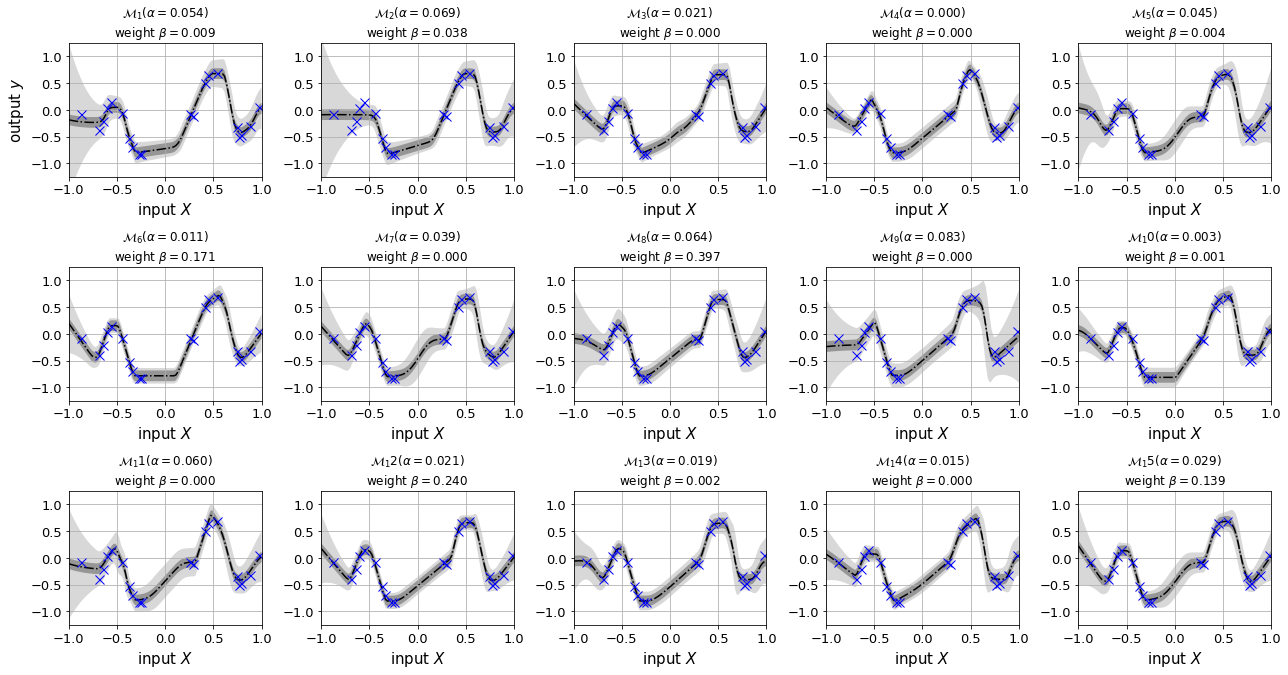

In [14]:
stat_to_plot = 'std'
weights_attribute = 'weights_kic_smoothed'

titles = [r'$\mathcal{}_{}(\alpha={:.3f})$'.format('{M}', i+1, alpha)+'\n'+r'weight $\beta={:.3f}$'.format(w_) 
          for i, (alpha, w_) in enumerate(zip(alpha_list, getattr(model_aving_3, weights_attribute)))]
fig0 = plot_regressors(regressors=model_aving_3.regressors, stat_to_plot=stat_to_plot, 
                       titles=titles, figsize=(18, 3. * 4), ns=10000, ncols=5, nrows=4)

## Look at problem when re-fitting

In [7]:
alpha_list_test = [0.09908007, 0.00515315, 0.06653683, 0.03648742]
random_seed_list_test = [4382, 7615, 4825, 8237]

In [8]:
model_aving_test = ModelAveragingLOOalphaBB(
    nn_dict=nn, training_data=(xn, yn), training_dict=training_dict, n_bootstrap=100,
    alpha_list=alpha_list_test, random_seed_list=random_seed_list_test)

model_aving_2_test = ModelAveragingLOO(
    nn_dict=nn, training_data=(xn, yn), training_dict=training_dict, n_bootstrap=100,
    alpha_list=alpha_list_test, random_seed_list=random_seed_list_test)

Adding model with alpha=0.09908007

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Adding model with alpha=0.00515315
Adding model with alpha=0.06653683
Adding model with alpha=0.03648742
Adding model with alpha=0.09908007
Adding model with alpha=0.00515315
Adding model with alpha=0.06653683
Adding model with alpha=0.03648742


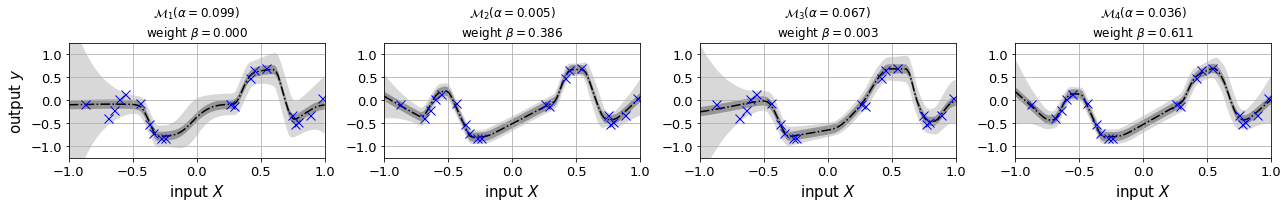

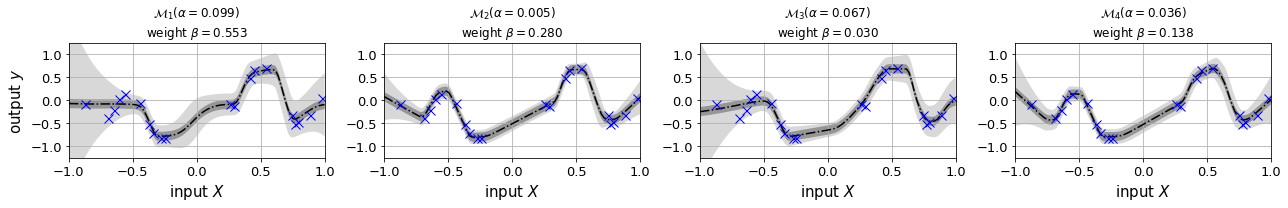

In [9]:
stat_to_plot = 'std'
weights_attribute = 'weights_elpd_bb'

titles = [r'$\mathcal{}_{}(\alpha={:.3f})$'.format('{M}', i+1, alpha)+'\n'+r'weight $\beta={:.3f}$'.format(w_) 
          for i, (alpha, w_) in enumerate(zip(alpha_list_test, getattr(model_aving_test, weights_attribute)))]
fig0 = plot_regressors(regressors=model_aving_test.regressors, stat_to_plot=stat_to_plot, 
                       titles=titles, figsize=(18, 3.), ns=10000, ncols=4)

titles = [r'$\mathcal{}_{}(\alpha={:.3f})$'.format('{M}', i+1, alpha)+'\n'+r'weight $\beta={:.3f}$'.format(w_) 
          for i, (alpha, w_) in enumerate(zip(alpha_list_test, getattr(model_aving_2_test, weights_attribute)))]
fig0 = plot_regressors(regressors=model_aving_2_test.regressors, stat_to_plot=stat_to_plot, 
                       titles=titles, figsize=(18, 3.), ns=10000, ncols=4)

Adding model with alpha=0.09908007
Adding model with alpha=0.00515315
Adding model with alpha=0.06653683
Adding model with alpha=0.03648742


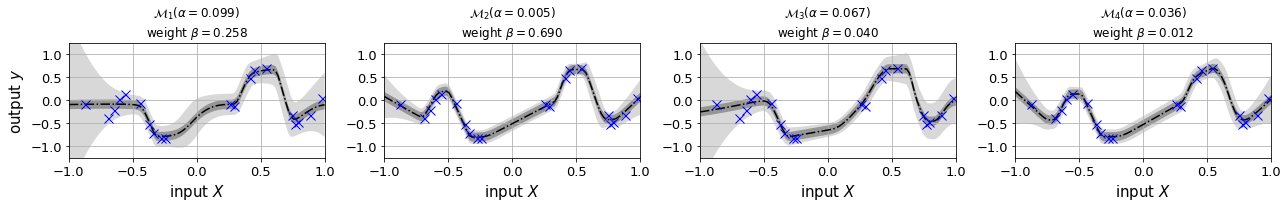

In [10]:
model_aving_2_test2 = ModelAveragingLOO(
    nn_dict=nn, training_data=(xn, yn), training_dict=training_dict, n_bootstrap=100,
    alpha_list=alpha_list_test, random_seed_list=random_seed_list_test, resample_seed_LOO=1)

stat_to_plot = 'std'
weights_attribute = 'weights_elpd_bb'
titles = [r'$\mathcal{}_{}(\alpha={:.3f})$'.format('{M}', i+1, alpha)+'\n'+r'weight $\beta={:.3f}$'.format(w_) 
          for i, (alpha, w_) in enumerate(zip(alpha_list_test, getattr(model_aving_2_test2, weights_attribute)))]
fig0 = plot_regressors(regressors=model_aving_2_test2.regressors, stat_to_plot=stat_to_plot, 
                       titles=titles, figsize=(18, 3.), ns=10000, ncols=4)

In [ ]:
model_aving_2_test2 = ModelAveragingLOO(
    nn_dict=nn, training_data=(xn, yn), training_dict=training_dict, n_bootstrap=100,
    alpha_list=alpha_list_test, random_seed_list=random_seed_list_test, resample_seed_LOO=1)

stat_to_plot = 'std'
weights_attribute = 'weights_elpd_bb'
titles = [r'$\mathcal{}_{}(\alpha={:.3f})$'.format('{M}', i+1, alpha)+'\n'+r'weight $\beta={:.3f}$'.format(w_) 
          for i, (alpha, w_) in enumerate(zip(alpha_list_test, getattr(model_aving_2_test2, weights_attribute)))]
fig0 = plot_regressors(regressors=model_aving_2_test2.regressors, stat_to_plot=stat_to_plot, 
                       titles=titles, figsize=(18, 3.), ns=10000, ncols=4)

Adding model with alpha=0.09908007
Adding model with alpha=0.00515315
Adding model with alpha=0.06653683


Adding model with alpha=0.09908007
Adding model with alpha=0.00515315
Adding model with alpha=0.06653683
Adding model with alpha=0.03648742


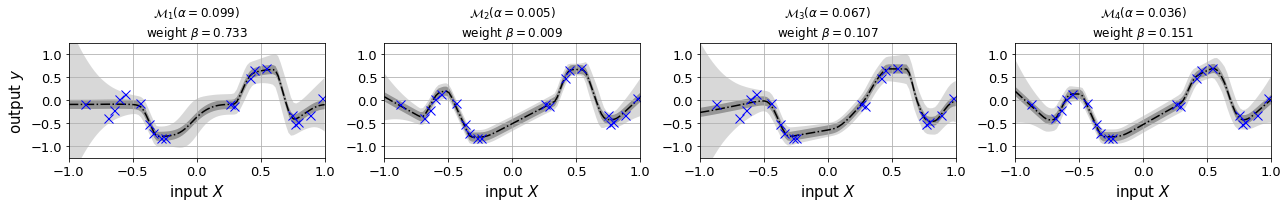

In [11]:
model_aving_2_test3 = ModelAveragingLOO(
    nn_dict=nn, training_data=(xn, yn), training_dict=training_dict, n_bootstrap=100,
    alpha_list=alpha_list_test, random_seed_list=random_seed_list_test, resample_seed_LOO=10)

stat_to_plot = 'std'
weights_attribute = 'weights_elpd_bb'
titles = [r'$\mathcal{}_{}(\alpha={:.3f})$'.format('{M}', i+1, alpha)+'\n'+r'weight $\beta={:.3f}$'.format(w_) 
          for i, (alpha, w_) in enumerate(zip(alpha_list_test, getattr(model_aving_2_test3, weights_attribute)))]
fig0 = plot_regressors(regressors=model_aving_2_test3.regressors, stat_to_plot=stat_to_plot, 
                       titles=titles, figsize=(18, 3.), ns=10000, ncols=4)

0.09908007


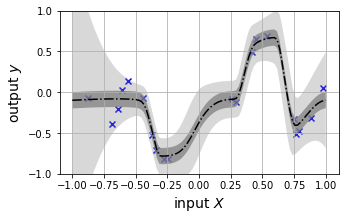

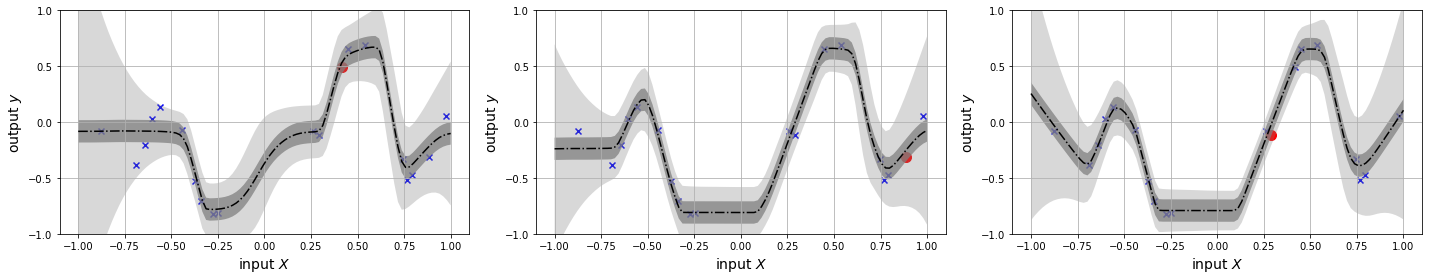

In [22]:
stat_to_plot = 'std'   # 'std' or 'perc'
dict_predict = {'return_std': False, 'return_percentiles': (2.5, 97.5), 'return_MC': 0, 
                'aleatoric_in_std_perc': True, 'aleatoric_in_MC': False, 'ns': 10000}
if stat_to_plot == 'std':
    dict_predict.update({'return_std': True, 'return_percentiles': ()})

alpha = alpha_list_test[0]
print(alpha)
random_seed = random_seed_list_test[0]
reg = alphaBB(alpha=alpha, random_seed=random_seed, **nn)
reg.fit(X=xn, y=yn, **training_dict)
y_mean, y_uq = reg.predict_uq(X=x_plot, **dict_predict)
fig, ax = plt.subplots(figsize=(5., 3.))
plot_mean_uq(x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax, y_mean=y_mean, var_aleatoric=var_n)
ax.scatter(xn, yn, marker='x', color='blue')
ax.set_ylim([-1, 1])
ax.set_yticks([-1., -0.5, 0., 0.5, 1.])
ax.grid(True)
plt.show()

# for ndata regressors
fig, ax = plt.subplots(ncols=3, figsize=(20, 4.))
for ind_data in range(3):
    # fit to data-i
    indices_data = [i for i in range(xn.shape[0]) if i != (xn.shape[0] - ind_data)]
    reg = alphaBB(alpha=alpha, random_seed=random_seed, **nn)
    reg.fit(X=xn[indices_data, :], y=yn[indices_data, :], **training_dict)
    y_mean, y_uq = reg.predict_uq(X=x_plot, **dict_predict)
    plot_mean_uq(x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax[ind_data], y_mean=y_mean, var_aleatoric=var_n)
    ax[ind_data].scatter(xn[indices_data], yn[indices_data], marker='x', color='blue')
    ax[ind_data].scatter(xn[-1-ind_data], yn[-1-ind_data], marker='o', color='red', s=100)
    ax[ind_data].set_ylim([-1, 1])
    ax[ind_data].set_yticks([-1., -0.5, 0., 0.5, 1.])
    ax[ind_data].grid(True)
fig.tight_layout()
plt.show()